In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import kagglehub
iqothnccd_lung_cancer_dataset_path = kagglehub.dataset_download('dimassatriaprayoga/iqothnccd-lung-cancer-dataset')
print("Dataset download from : ", iqothnccd_lung_cancer_dataset_path)
print("Data source import complete.")

100%|██████████| 199M/199M [00:00<00:00, 229MB/s]

Extracting files...


Dataset download from :  /root/.cache/kagglehub/datasets/dimassatriaprayoga/iqothnccd-lung-cancer-dataset/versions/1
Data source import complete.


# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import random
import os
import imageio.v2 as imageio
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import tensorflow as tf
import keras

from PIL import Image
from plotly.subplots import make_subplots
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
# Menentukan Lokasi Dataset dan Kategori
directory = os.path.join(iqothnccd_lung_cancer_dataset_path, 'The IQ-OTHNCCD lung cancer dataset', 'The IQ-OTHNCCD lung cancer dataset')
# Menentukan kategori kelas citra
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

# Menampilkan Informasi Dataset
print(f"Dataset directory: {directory}")
print(f"Image categories: {categories}", "\n")

# Melihat isi folder utama dataset
print(os.listdir(iqothnccd_lung_cancer_dataset_path))
# Melihat isi folder dataset sebenarnya
print(os.listdir(directory))

Dataset directory: /root/.cache/kagglehub/datasets/dimassatriaprayoga/iqothnccd-lung-cancer-dataset/versions/1/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset
Image categories: ['Bengin cases', 'Malignant cases', 'Normal cases'] 

['Test cases', 'The IQ-OTHNCCD lung cancer dataset']
['Normal cases', 'Malignant cases', 'Bengin cases', 'IQ-OTH_NCCD lung cancer dataset.txt']


* Test cases
* The IQ-OTHNCCD lung cancer dataset
  * The IQ-OTHNCCD lung cancer dataset
    * Bengin cases
    * Malignant cases
    * Normal cases
  

# Image Size Variations

In [ ]:
size_data = {}
# Mengambil nama kelas saat ini dan menetapkannya ke variabel
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    # Melakukan iterasi melalui
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        # Menambah hitungan jika ukuran sudah ada
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        # Menginisialisasi hitungan baru jika ukuran belum pernah ditemukan
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict
size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


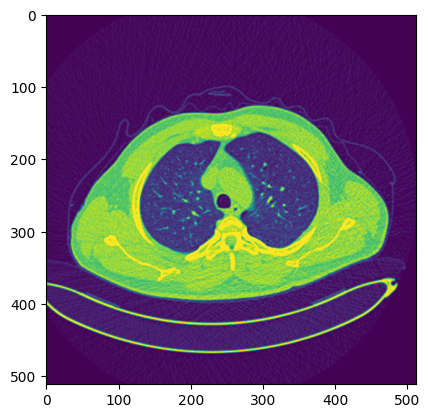


Malignant cases


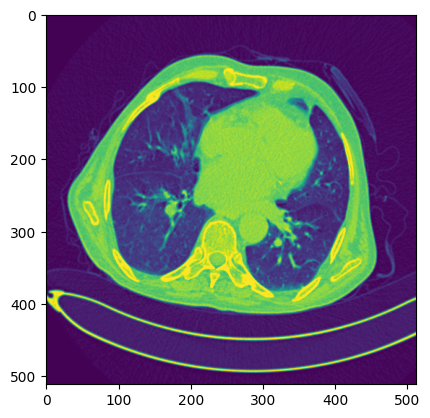


Normal cases


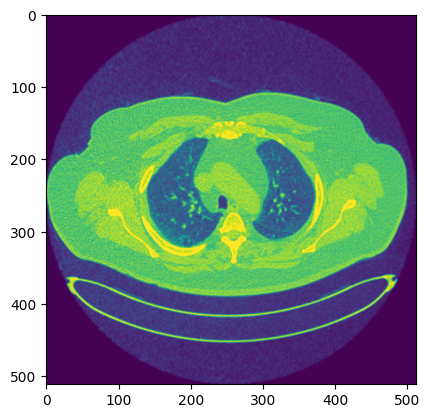

In [ ]:
# Iterasi kategori
for i in categories:
  path = os.path.join(directory, i)
  class_num = categories.index(i)

  # Membangun path
  for file in os.listdir(path):
    filepath = os.path.join(path, file)
    print(i)
    img = cv2.imread(filepath, 0)

    # Membaca dan menampilkan gambar
    plt.imshow(img)
    plt.show()
    print("")
    break

# Image Preprocessing and Testing

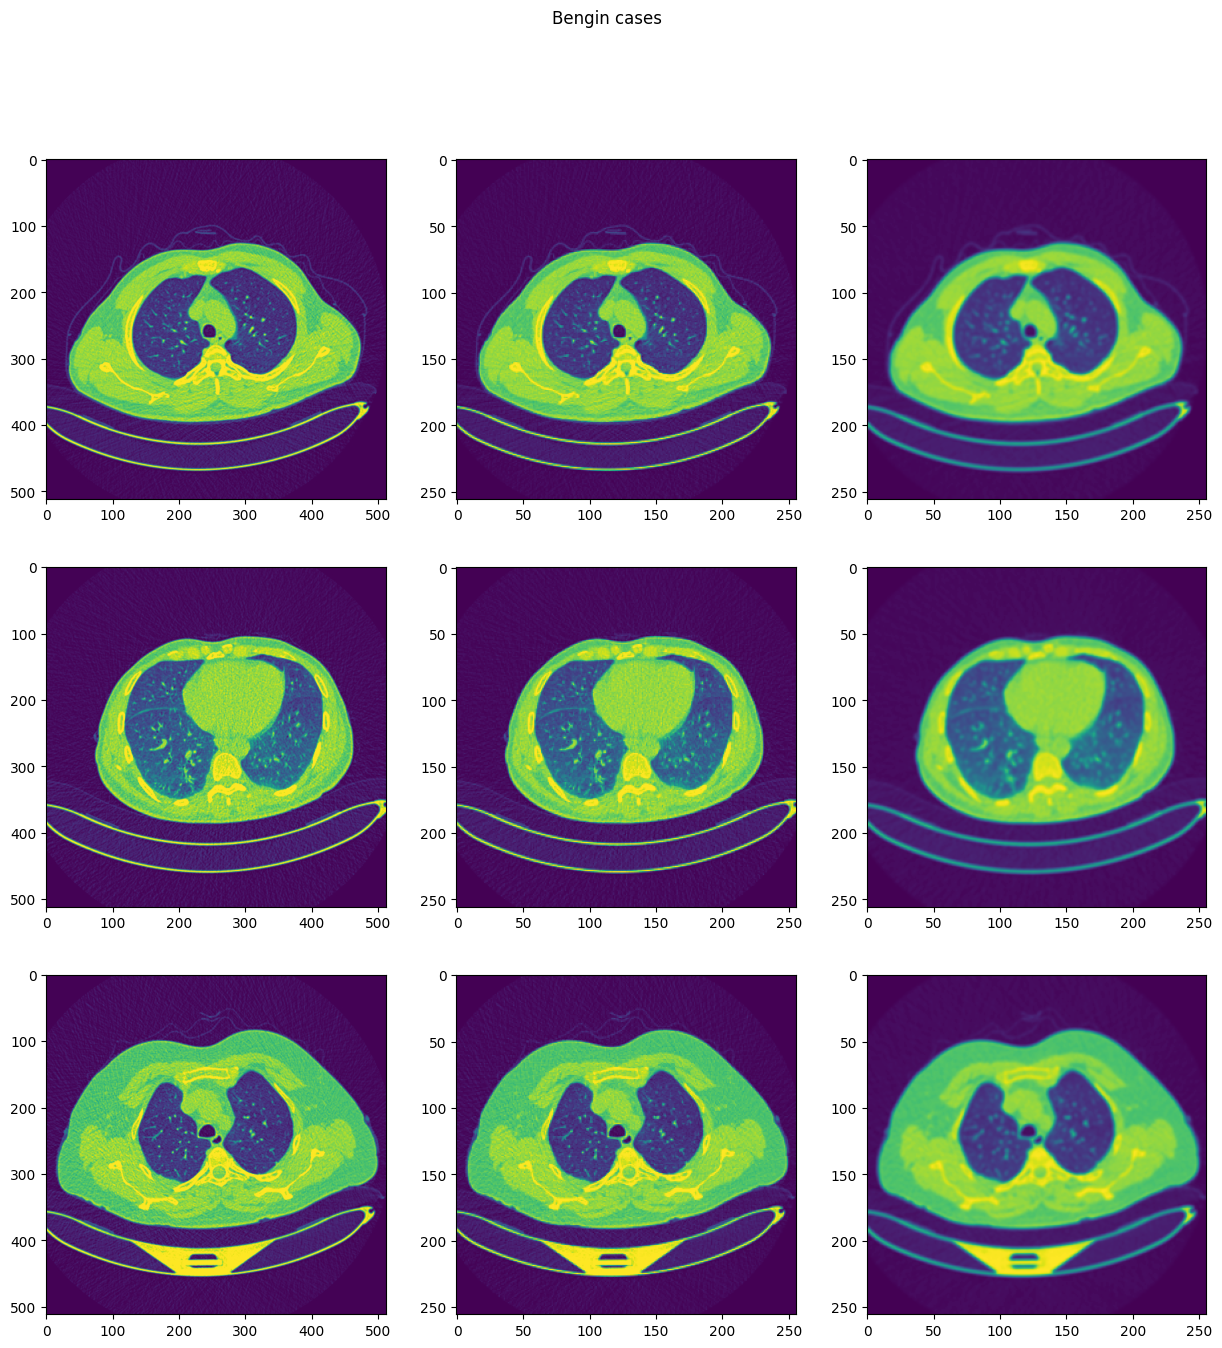

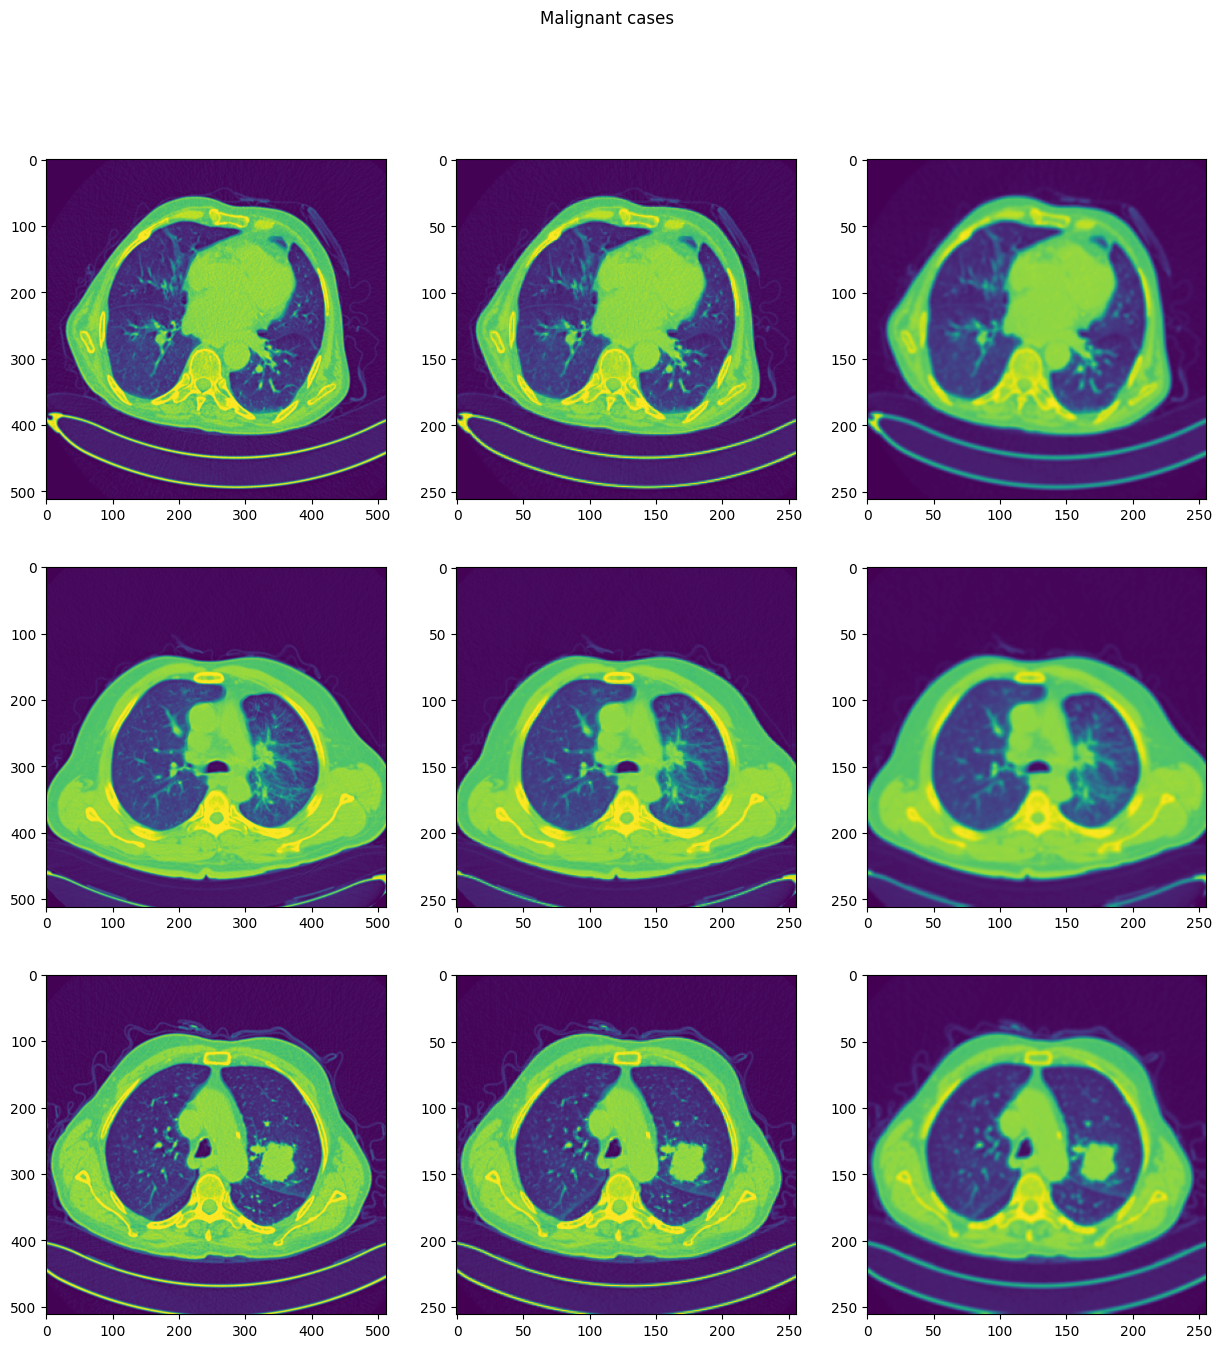

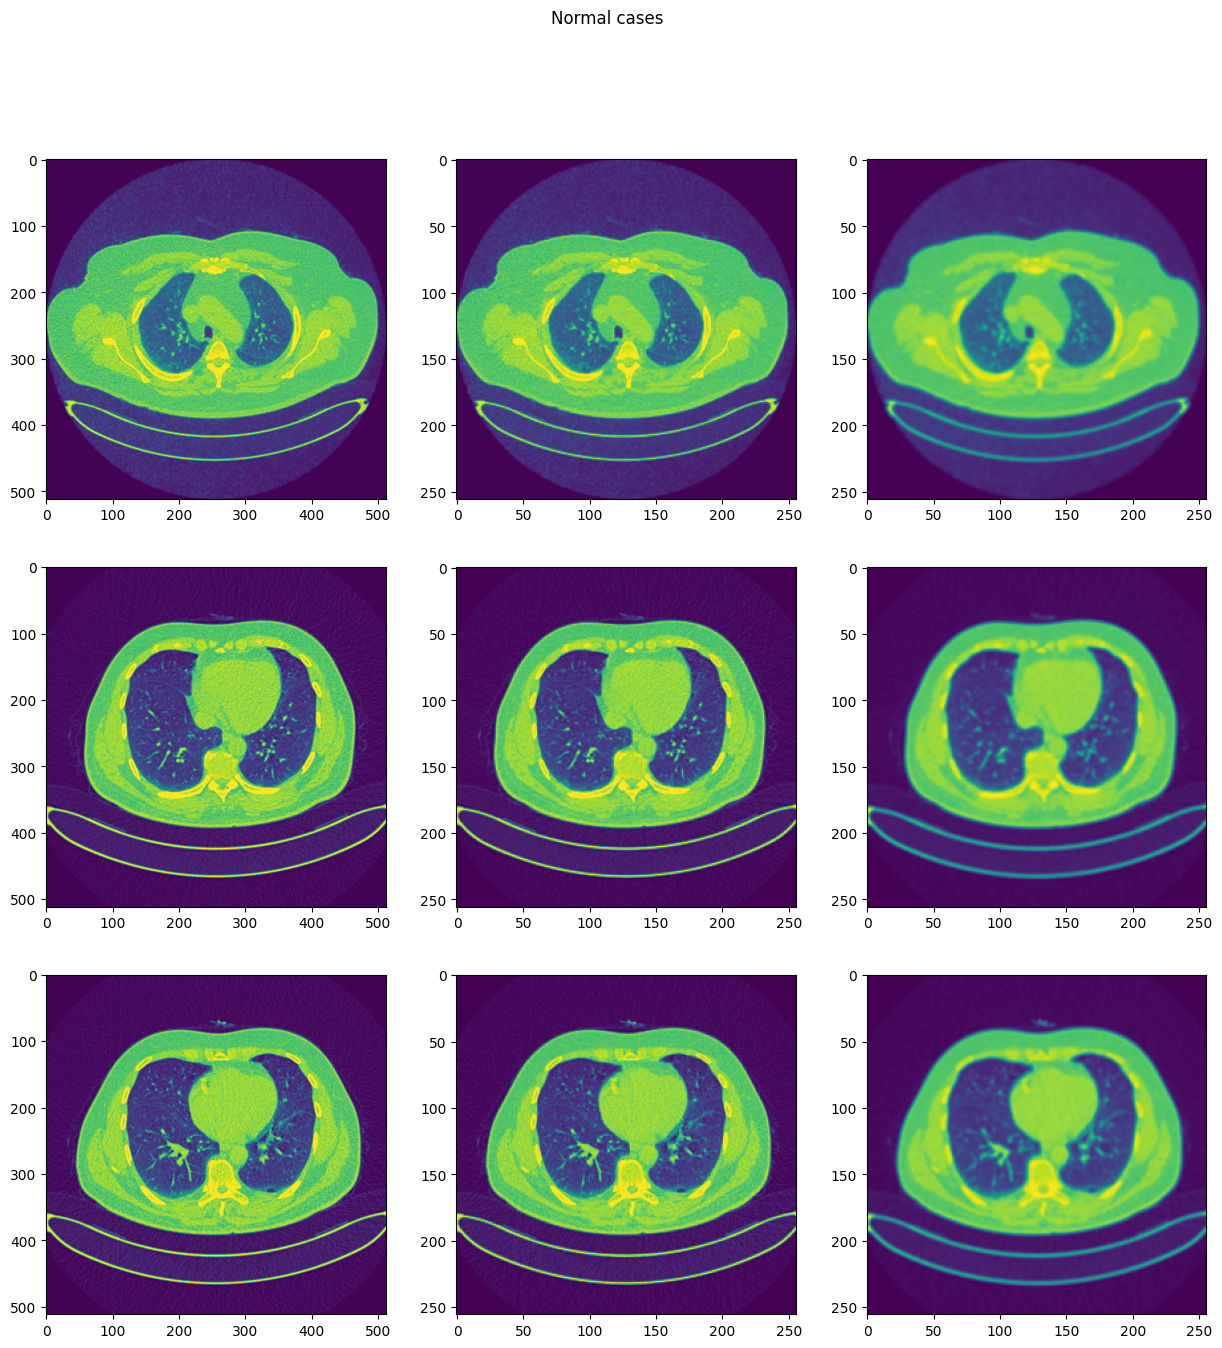

In [ ]:
img_size = 256

# Loop berjalan sekali untuk setiap kategori yang ada dalam daftar categories.
for i in categories:
  cnt, samples = 0, 3
  fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
  fig.suptitle(i)

  path = os.path.join(directory, i)
  class_num = categories.index(i)

  # Untuk setiap file (gambar) di dalam folder kategori yang sedang diproses oleh loop terluar.
  for curr_cnt, file in enumerate(os.listdir(path)):
    filepath = os.path.join(path, file)
    img = cv2.imread(filepath, 0)
    img0 = cv2.resize(img, (img_size, img_size))
    img1 = cv2.GaussianBlur(img0, (5, 5), 0)

    ax[cnt, 0].imshow(img)
    ax[cnt, 1].imshow(img0)
    ax[cnt, 2].imshow(img1)
    cnt += 1
    if cnt == samples:
      break

plt.show()

# Preparing Data

In [ ]:
from collections import Counter
import numpy as np

data = []
img_size = 256

# Mengambil dan Memproses Gambar
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # Pra-Pemrosesan
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

# Mengacak Data
random.shuffle(data)

# Memisahkan Fitur dan Label
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# Normalisasi Data
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
# Menyiapkan data dengan benar, memastikan evaluasi model yang adil, dan membangun model yang kuat
X_train, X_test, y_train, y_test = train_test_split(
  X, y, random_state=42, stratify=y) # Sama dengan train = 0.75 dan test = 0.25

print(len(X_train), X_train.shape)
print(len(X_test), X_test.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


# Applying SMOTE to oversample the data

In [ ]:
print(Counter(y_train))
print(Counter(y_test))

Counter({np.int64(1): 420, np.int64(2): 312, np.int64(0): 90})
Counter({np.int64(1): 141, np.int64(2): 104, np.int64(0): 30})


In [ ]:
print(len(X_train), X_train.shape)
X_train = X_train.reshape(
    X_train.shape[0],
    img_size*img_size*1)
print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [ ]:
# Smote Tuning Hyperparameter
print("Before SMOTE:", Counter(y_train))
smote = SMOTE()
# Reshape X_train to 2D before applying SMOTE
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_sampled))

Before SMOTE: Counter({np.int64(1): 420, np.int64(2): 312, np.int64(0): 90})
After SMOTE: Counter({np.int64(1): 420, np.int64(0): 420, np.int64(2): 420})


In [ ]:

X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


# Model Building with SMOTE data

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Filter bertahap meningkat (32 → 64 → 128)
# BatchNormalization untuk stabilitas
# Dropout untuk mencegah overfitting
# Dense layer yang lebih representatif
# Optimizer yang lebih stabil (misalnya Adam)

# Input Layer
input_tensor = Input(shape=X_train.shape[1:])

# Block 1
x = Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# Block 2
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# Block 3
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# Fully Connected
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer (3 kelas)
output_tensor = Dense(3, activation='softmax')(x)
model1 = Model(inputs=input_tensor, outputs=output_tensor)
model1.summary()

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,811 (64.36 MB)

 Trainable params: 16,871,107 (64.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# optimizer = "adam" # Adaptive Movement

model1.compile(
  loss = 'sparse_categorical_crossentropy',
  optimizer = Adam(learning_rate=0.001),
  metrics = ['accuracy']
)

history1 = model1.fit(
  X_train_sampled,
  y_train_sampled,
  batch_size=16, # Batch_size
  epochs=10, #
  validation_data=(X_test, y_test),
  verbose=1
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - accuracy: 0.9935 - loss: 0.0391 - val_accuracy: 0.4109 - val_loss: 6.6374
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9757 - loss: 0.0706 - val_accuracy: 0.8764 - val_loss: 0.3352
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9827 - loss: 0.0538 - val_accuracy: 0.6327 - val_loss: 1.7188
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9840 - loss: 0.0607 - val_accuracy: 0.9673 - val_loss: 0.0746
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9887 - loss: 0.0337 - val_accuracy: 0.9636 - val_loss: 0.2446
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9918 - loss: 0.0337 - val_accuracy: 0.7564 - val_loss: 0.8632
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9870 - loss: 0.0404 - val_accuracy: 0.9891 - val_loss: 0.0407
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9928 - loss: 0.0293 - val_accuracy: 0.6073 -

# Results

In [ ]:
# Prediksi
y_pred = model1.predict(X_test, verbose=1)

# Evaluasi
print("Classification Report CNN:")
print(classification_report(y_test, np.argmax(y_pred, axis=1)))

print("\nConfusion Matrix CNN:")
print(confusion_matrix(y_true=y_test, y_pred=np.argmax(y_pred, axis=1)))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
Classification Report CNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      0.99      1.00       141
           2       0.99      1.00      1.00       104

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275


Confusion Matrix CNN:
[[ 30   0   0]
 [  0 140   1]
 [  0   0 104]]


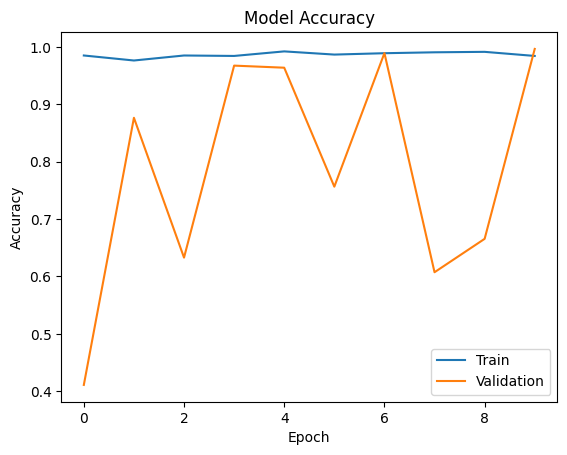

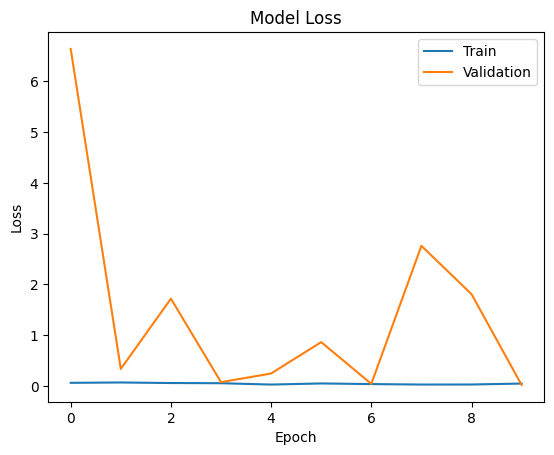

In [ ]:
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model Building with Class Weighted Approach

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

model2 = Sequential()

# Block 1
model2.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                  input_shape=X_train.shape[1:]))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# Block 2
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# Block 3
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# Fully Connected
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Output Layer
model2.add(Dense(3, activation='softmax'))
model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,811 (64.36 MB)

 Trainable params: 16,871,107 (64.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
optimizer = Adam(learning_rate=0.001)

model2.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

history2 = model2.fit(
  X_train_sampled,
  y_train_sampled,
  batch_size=16, # Batch_size
  epochs=10, #
  validation_data=(X_test, y_test),
  verbose=1
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.7404 - loss: 0.7201 - val_accuracy: 0.1091 - val_loss: 78.8603
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9565 - loss: 0.1495 - val_accuracy: 0.3782 - val_loss: 114.1722
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9742 - loss: 0.0945 - val_accuracy: 0.3782 - val_loss: 117.4848
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9858 - loss: 0.0592 - val_accuracy: 0.3782 - val_loss: 102.3001
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9842 - loss: 0.0595 - val_accuracy: 0.3782 - val_loss: 90.7550
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9942 - loss: 0.0340 - val_accuracy: 0.3709 - val_loss: 54.2874
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9895 - loss: 0.0457 - val_accuracy: 0.3927 - val_loss: 34.1226
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9919 - loss: 0.0330 - val_accuracy

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_model2 = model2.predict(X_test, verbose=1)

print("Classification Report for Model 2:")
print(classification_report(y_test, np.argmax(y_pred_model2, axis=1)))

print("\nConfusion Matrix for Model 2:")
print(confusion_matrix(y_true=y_test, y_pred=np.argmax(y_pred_model2, axis=1)))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step
Classification Report for Model 2:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.98      0.99      0.99       141
           2       1.00      0.97      0.99       104

    accuracy                           0.98       275
   macro avg       0.97      0.98      0.97       275
weighted avg       0.98      0.98      0.98       275


Confusion Matrix for Model 2:
[[ 29   1   0]
 [  1 140   0]
 [  1   2 101]]


In [ ]:
new_weights = {
  0: X_train.shape[0]/(3*Counter(y_train)[0]),
  1: X_train.shape[0]/(3*Counter(y_train)[1]),
  2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [ ]:
history2 = model2.fit(
  X_train,
  y_train,
  batch_size=16,
  epochs=10,
  validation_data=(X_test, y_test),
  class_weight=new_weights)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9919 - loss: 0.0173 - val_accuracy: 0.4582 - val_loss: 4.0744
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9884 - loss: 0.0247 - val_accuracy: 0.6582 - val_loss: 1.0965
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9972 - loss: 0.0137 - val_accuracy: 0.5309 - val_loss: 24.3914
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9898 - loss: 0.0288 - val_accuracy: 0.4036 - val_loss: 3.2986
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9947 - loss: 0.0188 - val_accuracy: 0.7818 - val_loss: 0.5554
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9829 - loss: 0.0823 - val_accuracy: 0.4109 - val_loss: 5.8165
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9820 - loss: 0.1252 - val_accuracy: 0.4000 - val_loss: 7.5075
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9804 - loss: 0.0590 - val_accuracy: 0.5564 - 

# Results

In [ ]:
y_pred = model2.predict(X_test, verbose=1)
y_pred_test = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_test))

print(confusion_matrix(y_true=y_test, y_pred=y_pred_test))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.95      1.00      0.97       141
           2       1.00      0.92      0.96       104

    accuracy                           0.97       275
   macro avg       0.97      0.96      0.97       275
weighted avg       0.97      0.97      0.97       275

[[ 29   1   0]
 [  0 141   0]
 [  1   7  96]]


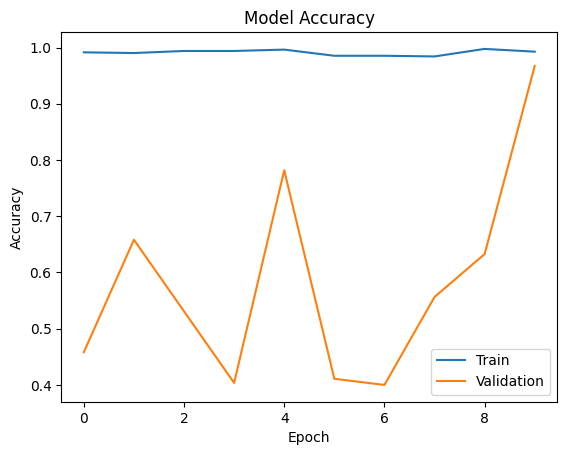

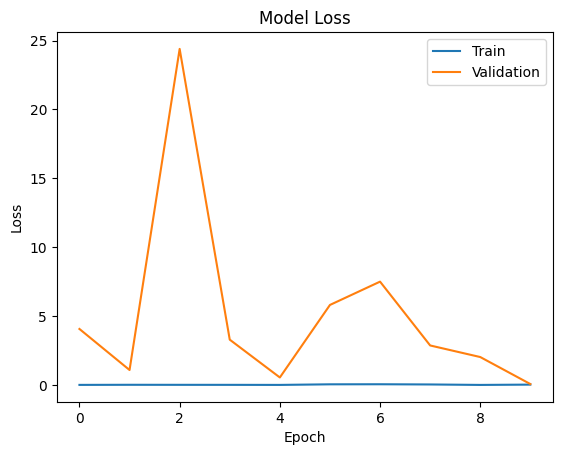

In [ ]:
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [116]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │     1,843,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,935,939 (7.39 MB)

 Trainable params: 1,935,939 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

# Data Augmentation

In [117]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()

In [124]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_test, y_test, batch_size=8)

In [125]:
model3.compile(
  loss='sparse_categorical_crossentropy',
  optimizer = Adam(learning_rate=0.001),
  metrics=['accuracy'])

history3 = model3.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=new_weights
  )

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.4213 - loss: 1.4068 - val_accuracy: 0.6000 - val_loss: 0.8512
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6031 - loss: 0.9258 - val_accuracy: 0.6545 - val_loss: 0.8457
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6649 - loss: 0.7357 - val_accuracy: 0.8000 - val_loss: 0.5377
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8071 - loss: 0.5220 - val_accuracy: 0.8509 - val_loss: 0.4057
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8498 - loss: 0.4476 - val_accuracy: 0.9309 - val_loss: 0.2336
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8998 - loss: 0.3460 - val_accuracy: 0.7782 - val_loss: 0.6109
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8895 - loss: 0.2768 - val_accuracy: 0.9382 - val_loss: 0.1434
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9701 - loss: 0.1303 - val_acc

In [127]:
y_pred = model3.predict(X_test, verbose=1)
y_pred_test = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_true=y_test, y_pred=y_pred_test))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        30
           1       0.99      0.96      0.97       141
           2       0.95      0.92      0.94       104

    accuracy                           0.94       275
   macro avg       0.90      0.94      0.91       275
weighted avg       0.95      0.94      0.94       275

[[ 28   1   1]
 [  2 135   4]
 [  7   1  96]]


In [128]:
# Buatkan Algoritma Naive Bias Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Reshape ke 2D (sama seperti KNN)
X_train_nb = X_train_sampled.reshape(X_train_sampled.shape[0], -1)
X_test_nb = X_test.reshape(X_test.shape[0], -1)

# Inisialisasi dan training model Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_nb, y_train_sampled)

# Prediksi pada data validasi
y_pred_nb = nb_model.predict(X_test_nb)

# Evaluasi model
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("\nNaive Bayes Confusion Matrix:")
print(confusion_matrix(y_true=y_test, y_pred=y_pred_nb))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.80      0.52        30
           1       0.93      0.60      0.73       141
           2       0.61      0.72      0.66       104

    accuracy                           0.67       275
   macro avg       0.64      0.71      0.64       275
weighted avg       0.75      0.67      0.68       275


Naive Bayes Confusion Matrix:
[[24  4  2]
 [12 84 45]
 [27  2 75]]


In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Reshape ke 2D (WAJIB untuk KNN)
X_train_knn = X_train.reshape(X_train.shape[0], -1)
X_test_knn  = X_test.reshape(X_test.shape[0], -1)

# Pipeline: Scaling + KNN (KNN sensitif skala!)
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(
        n_neighbors=4,        # 🔥 ganjil → hindari tie
        weights='distance',   # 🔥 kontribusi tetangga dekat lebih besar
        metric='minkowski',   # default (euclidean)
        n_jobs=-1
    ))
])

# Training model
knn_model.fit(X_train_knn, y_train)

# Prediksi data uji
y_pred_knn = knn_model.predict(X_test_knn)

# Evaluasi model
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

print("\nKNN Confusion Matrix:")
print(confusion_matrix(y_true=y_test, y_pred=y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       1.00      1.00      1.00       141
           2       0.97      1.00      0.99       104

    accuracy                           0.99       275
   macro avg       0.99      0.97      0.98       275
weighted avg       0.99      0.99      0.99       275


KNN Confusion Matrix:
[[ 27   0   3]
 [  0 141   0]
 [  0   0 104]]


In [141]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Reshape ke 2D (sama seperti NB & KNN)
X_train_svm = X_train_sampled.reshape(X_train_sampled.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)

# Pipeline: Scaling + SVM (WAJIB scaling!)
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',        # kernel non-linear (default & kuat)
        C=1.0,               # regularisasi
        gamma='scale',       # aman untuk data fitur besar
        class_weight='balanced',  # 🔥 penting untuk imbalance
        random_state=42
    ))
])

# Training model
# Fix: Use y_train_sampled instead of y_train to match X_train_svm sample size
svm_model.fit(X_train_svm, y_train_sampled)

# Prediksi pada data validasi
y_pred_svm = svm_model.predict(X_test_svm)

# Evaluasi model
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_true=y_test, y_pred=y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.99      1.00      1.00       141
           2       1.00      1.00      1.00       104

    accuracy                           1.00       275
   macro avg       1.00      0.99      0.99       275
weighted avg       1.00      1.00      1.00       275


SVM Confusion Matrix:
[[ 29   1   0]
 [  0 141   0]
 [  0   0 104]]


In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Buatkan menggunakan random forest classifier
X_train_rf = X_train_sampled.reshape(X_train_sampled.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# Pipeline: (Scaling optional) + Random Forest
rf_model = Pipeline([
    # ('scaler', StandardScaler()),  # ❌ tidak wajib untuk RF
    ('rf', RandomForestClassifier(
        n_estimators=300,        # 🔥 jumlah pohon
        max_depth=None,          # biarkan tumbuh optimal
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced', # 🔥 penting untuk imbalance
        random_state=42,
        n_jobs=-1
    ))
])

# Training model
rf_model.fit(X_train_rf, y_train_sampled)

# Prediksi data validasi
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluasi model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_true=y_test, y_pred=y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       141
           2       1.00      1.00      1.00       104

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275


Random Forest Confusion Matrix:
[[ 30   0   0]
 [  0 141   0]
 [  0   0 104]]


In [144]:
#
def predict_new_image(image_path, model):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  if img is None:
      print(f"Error: Could not load image from {image_path}")
      return None

  return img

In [146]:
#
def predict_new_image(image_path, model, img_size=256, categories=None):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    # Preprocess the image
    img_resized = cv2.resize(img, (img_size, img_size)) # Resize to img_size x img_size
    img_normalized = img_resized / 255.0 # Normalize pixel values

    # Reshape for prediction based on model type
    # For models like RandomForestClassifier (rf_model) that expect a 2D input
    if hasattr(model, 'predict'): # Check if it's a scikit-learn pipeline/model
        img_reshaped = img_normalized.reshape(1, img_size * img_size)
        prediction = model.predict(img_reshaped)
        predicted_class_index = prediction[0]
    else: # Assuming it's a Keras/TensorFlow model expecting 4D input
        img_reshaped = img_normalized.reshape(1, img_size, img_size, 1)
        prediction = model.predict(img_reshaped, verbose=0)
        predicted_class_index = np.argmax(prediction)

    # Map numerical prediction to class label if categories are provided
    if categories and predicted_class_index < len(categories):
        predicted_label = categories[predicted_class_index]
    else:
        predicted_label = f"Class {predicted_class_index}"

    return img, predicted_label

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Predicted class for the image: Malignant cases


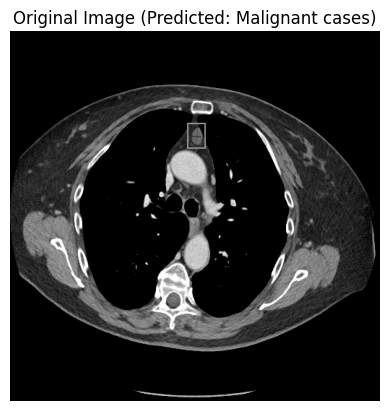

In [153]:
#
random_image_path_1 = "/content/drive/MyDrive/CT_Scan_Lung/Data_Validasi_1.png"
original_image, predicted_class = predict_new_image(random_image_path_1, rf_model, categories=categories)

print(f'Predicted class for the image: {predicted_class}')

plt.imshow(original_image, cmap='gray')
plt.title(f'Original Image (Predicted: {predicted_class})')
plt.axis('off')
plt.show()